In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

In [9]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


### Compare DC methods

In [10]:
data_path = '/data_volume/memento/simulation/dc/'

In [11]:
result = pd.read_csv(data_path + 'memento_dc.csv')
schot_df = pd.read_csv(data_path + 'dc_schot.csv')
result = result.merge(schot_df, on=['gene_1', 'gene_2'])
result['sig'] = (result['gene_1'] < 400) & (result['gene_2'] < 400)
result['null'] = ~result['sig']

result['schot'] = result['pvalEstimated']
result['memento'] = result['corr_pval']

result['schot_es'] = result['globalHigherOrderFunction']
result['memento_es'] = result['corr_coef']

with open(data_path + 'dc_true_effect_size.pkl', 'rb') as f:
    true_es_matrix = pkl.load(f)
indices = list(itertools.combinations(np.arange(true_es_matrix.shape[0]), 2))
pos_idxs = pd.DataFrame(indices, columns=['gene_1', 'gene_2'])
a,b = zip(*indices)
pos_idxs['true_es'] = true_es_matrix[(a,b)]

result = result.merge(pos_idxs, on=['gene_1', 'gene_2'], how='left')
result['true_es'] = result['true_es'].fillna(value=0)
result['memento_sign'] = (result['memento_es']*result['true_es']) > 0
result['schot_sign'] = (result['schot_es']*result['true_es']) > 0

In [22]:
n=10
thresholds = {
    'memento':np.logspace(-3, -1, n),
    'schot':np.logspace(-3, -1, n)}
tpr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in ['memento', 'schot']:
    tpr = []
    fpr = []
    fdr = []

    for thresh in thresholds[method]:
    
        tpr.append( ( (result.query('sig')[method] < thresh) & result.query('sig')[method+'_sign']   ).mean())
        fdr.append(    (result.query('{} < {}'.format(method, thresh))['null']   |   ~result.query('{} < {}'.format(method, thresh))[method+'_sign']    ).mean())
        fpr.append((result.query('null')[method] < thresh).mean())
    tpr_dict[method] = tpr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

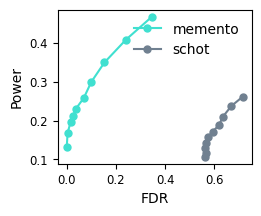

In [26]:
plt.figure(figsize=(2.5, 2))

for method in ['memento', 'schot']:
    plt.plot(fdr_dict[method], tpr_dict[method],'-o', label=method, ms=5)
plt.ylabel('Power'); plt.xlabel('FDR')
plt.legend(frameon=False, loc='upper right')
plt.savefig('fdr_tpr_dc.pdf', bbox_inches='tight')

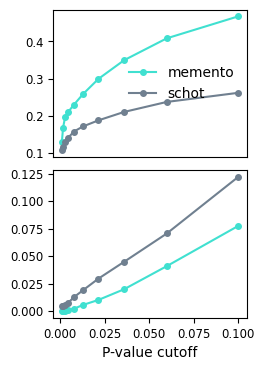

In [15]:
plt.figure(figsize=(2.5, 4))
plt.subplots_adjust(hspace=0.09)
plt.subplot(2, 1, 1)
for method in ['memento', 'schot']:
    plt.plot(thresholds[method], tpr_dict[method], '-o', label=method, ms=4)
plt.legend(['memento', 'schot'], frameon=False, loc='center right')
plt.xticks([])

plt.subplot(2, 1, 2)
for method in ['memento', 'schot']:
    plt.plot(thresholds[method], fpr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.ylabel('FPR')
# plt.plot([0, 0.5], [0, 0.5], '--', color='red')
plt.xlabel('P-value cutoff')

plt.savefig('dc_comparison.pdf', bbox_inches='tight')

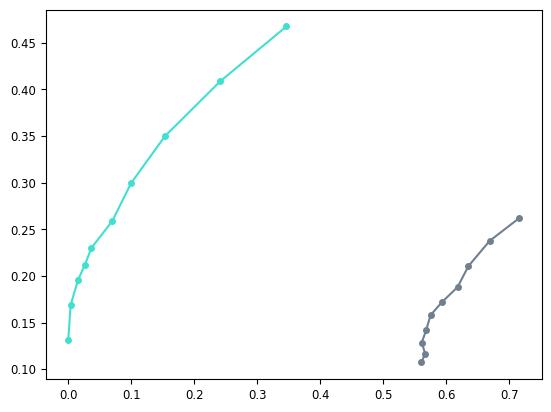

In [16]:
for method in ['memento', 'schot']:
    plt.plot(fdr_dict[method], tpr_dict[method],'-o', label=method, ms=4)